The purpose of this notebook is to show how to **read** research data in python.

For example,

*   `Ni-foil-XAS-data-from-ISS-beamline.dat` is X-ray absorption spectroscopy data from the ISS beamline of NSLS-II
*   `Ni-foil-XAS-data-from-QAS-beamline.dat` is X-ray absorption spectroscopy data from the QAS beamline of NSLS-II
*   `Ni_calib_20190301-150927_459ff6_0001_mean_tth.chi` is X-ray diffraction data from the XPD beamline of NSLS-II
*   `25KI-LiCl-KCl_25oC.xlsx` is an excel file from a benchtop XRD setup
*   `topas.inp` is an input file for the TOPAS XRD refinement program and `topas.out` is an output file from TOPAS
*   `bde401ed-ac56-45cd-b0c5_000000.h5` is an hdf file from X-ray fluoresence detector at XPD beamline of NSLS-II


It should be noted that although we make some figures in this notebook, its purpose is **NOT** for making pretty figures. Instead the main takeaway should be file reading.




***
# Imports


Let's import some libraries which will be useful throughout this notebook. `os`, `sys`, and `shutil` are libraries for navigating the system directories and running bash commands.

In [1]:
# general libraties that exist on most systems

import os
import importlib
import re

In [2]:
# The libraries that we will need in this notebook.
# If the required library doesn't exist, we install it via pip

required_packages   = {'numpy','xarray','pyFAI','ipympl','pandas','PIL','h5py','yaml'}

for rp in required_packages:
    try:
        print('Checking %s package'%rp)
        globals()[rp] = importlib.import_module(rp)
    except:
        print('Installing %s'%rp)
        !! pip install $rp
        globals()[rp] = importlib.import_module(rp)


import numpy as np
import xarray as xr
import pandas as pd
import h5py
import yaml

Checking numpy package
Checking h5py package
Checking xarray package
Checking PIL package
Checking pyFAI package
Checking ipympl package
Checking yaml package
Checking pandas package


In [3]:
# Here we check if this notebook is running on Google Colab.
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [4]:
# If the notebbok is running on Google Colab, we mount google drive to instance
# and enable enable_custom_widget_manager for ipympl package to work properly.
# See See: https://matplotlib.org/ipympl/ for ipympl

if IN_COLAB:
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # Enable enable_custom_widget_manager
    from google.colab import output
    output.enable_custom_widget_manager()

In [5]:
# importing matplotlib for plots.
%matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.constrained_layout.use'] = True

***
# Setting up the example data path

Before we begin, we assume this notebook and its data is on **Google Colab** so that in case it is, we can read in the data files from **Google Drive**. `os.chdir` sets your local path to the given directory (exactly like `cd` in terminal). You may need to adjust the path input if your directory structure is different.

In [6]:
if IN_COLAB:
    os.chdir('/content/drive/MyDrive/pySULI/notebooks') # Here we assume, pySULI repo is uploaded to Google Drive

if not os.path.isdir('example_data'):
    print('example_data is not found here. Please make sure it is in the same directory as this notebook.')

If we are not in Google Colab, we continue as we would on a personal machine. Make sure that you open jupyter-lab (or whatever IDE you are using) in the `pySULI` directory, so that the here command gives the correct location.

You can always use `os.getcwd()` to check where the current working directory is. `os.chdir('absolute or relative path')` will change the cwd to the entered path. `'..'` is the shortcut path for the next highest branch. For example; you are in `'pySULI/notebooks'`, `os.chdir('..')` will bring you to `'pySULI'`. In Python, it is convenient to switch cwd often to avoid entering long absolute directories.

**It is important to keep track of your cwd so you don't write files in the wrong places or try to read files that arent there.**

You can read about how abs/relative directories are listed in different OS [here](https://phoenixnap.com/kb/absolute-path-vs-relative-path).

The notebooks will always assume `here` is `'../pySULI/notebooks/'`. `example_data_path` will change from notebook to notebook depending on what files are relevant to that notebook.

In [7]:
here = os.getcwd()
example_data_path = 'example_data/file_types/'

os.listdir('%s/%s'%(here,example_data_path))

['xls', 'plain_text', 'netcdf', 'npy', 'image', 'hdf', 'yaml']

***
# reading plain text files (txt, dat..)


In [8]:
# navigate into plain_text directory
os.chdir('%s/%s/%s'%(here,example_data_path,'plain_text'))

# list the contents of directory
os.listdir()

['Ni_calib_20190301-150927_459ff6_0001_mean_tth.chi',
 'two-column-data.txt',
 'topas.out',
 'topas.inp',
 'topas.dat',
 'Ni-foil-XAS-data-from-ISS-beamline.dat',
 'Ni-foil-XAS-data-from-QAS-beamline.dat',
 'topas_modified.inp',
 'topas.xy']

With the `os.listdir()` command, we see all the files in out current working directory. `two-column-data.txt` in the `plain_text` directory is a simple two-column text file. The file can be imported into excel, and analyzed there.

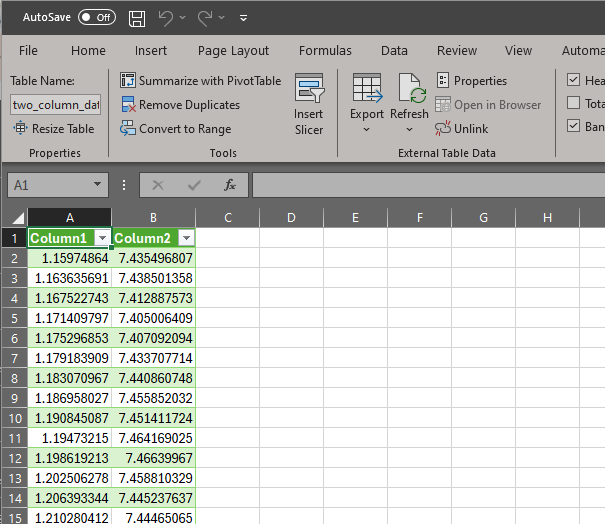

Although excel is powerful, it is inefficient for dealing with large amounts of data. Thankfully, Python has most if not all capabilities of excel, as well as many more. We only need 3-lines of code to read and plot the contents of this file.

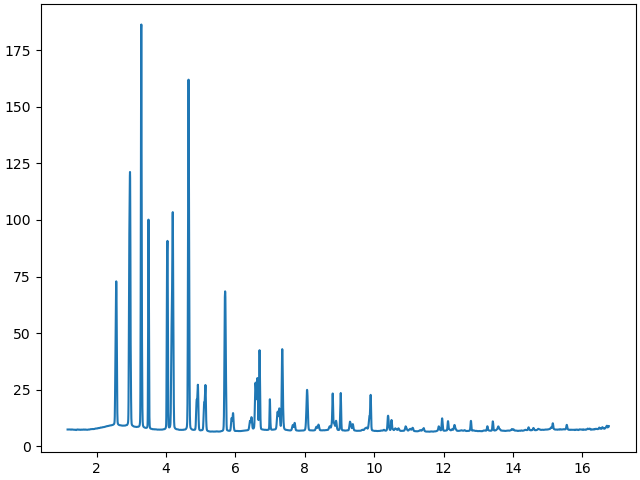

In [9]:
data = np.loadtxt('two-column-data.txt',unpack=True)
plt.figure()
plt.plot(data[0],data[1]);

However, the same lines **will not** work for the file `Ni_calib_20190301-150927_459ff6_0001_mean_tth.chi`. This file has some extra lines at the beginning, which are strings (text), and can not be converted to float (decimal number).


In [10]:
try:
    data = np.loadtxt('Ni_calib_20190301-150927_459ff6_0001_mean_tth.chi',unpack=True)
    plt.figure()
    plt.plot(data[0],data[1])
except Exception as exc:
    print(exc)

could not convert string '/nsls2/xf28id2/xpdUser/tiff_base/Ni_calib/integration/Ni_calib_20190301-150927_459ff6_0001_mean_tth to float64 at row 0, column 1.


You can use `head` linux bash command to see the first 10 lines of the file. When using bash commands, start with a `!`.

In [11]:
! head -n 10 Ni_calib_20190301-150927_459ff6_0001_mean_tth.chi

/nsls2/xf28id2/xpdUser/tiff_base/Ni_calib/integration/Ni_calib_20190301-150927_459ff6_0001_mean_tth
        This file contains integrated powder x-ray diffraction
        intensities.
        First column represents two theta values (degrees) and
        second column represents intensities and if there is
        a third column it represents the error values of intensities.
        Number of data points in the file : 3115
        ######################################################
7.483904475406880953e-03 6.011987304687499645e+00
1.406578056178594757e-02 7.987988471984863281e+00


We see that the first 7 lines do not contain data; lets skip them, and try to read the file again.

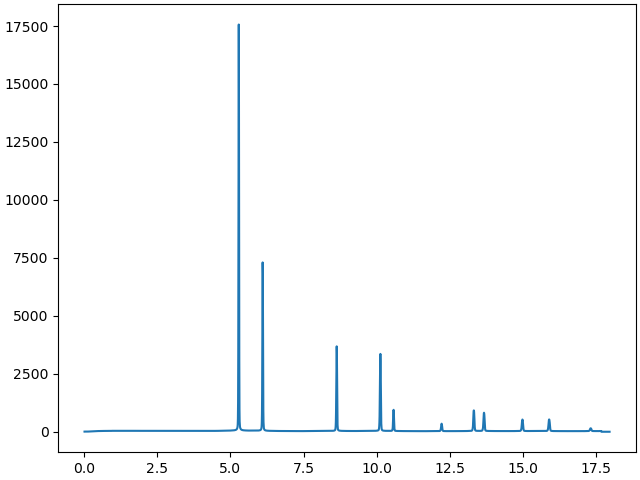

In [12]:
data = np.loadtxt('Ni_calib_20190301-150927_459ff6_0001_mean_tth.chi',unpack=True,skiprows=7)
plt.figure()
plt.plot(data[0],data[1]);

Now we want to read *Ni-foil-XAS-data-from-ISS-beamline.dat* file here

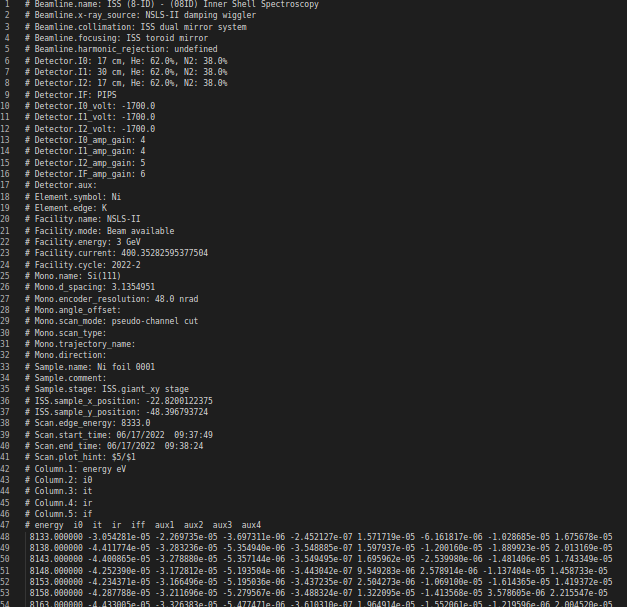

From the header lines, we can see first column is energy. We also see that the other columns are i0, it (transmission), ir (reference), and iff (fluoresence) channels. We can load the file and plot the data from the i0, it (transmission), ir (reference), iff (fluoresence) channels like this:


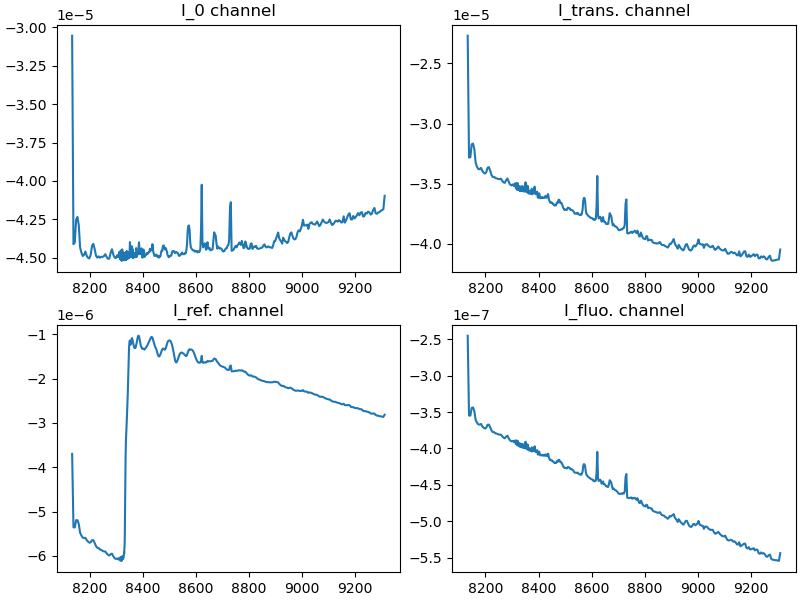

In [13]:
E, I0, It, Ir, If = np.loadtxt('Ni-foil-XAS-data-from-ISS-beamline.dat',unpack=True,usecols=[0,1,2,3,4])

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(2,2,1)
ax.plot(E,I0)
ax.set_title('I_0 channel')

ax = fig.add_subplot(2,2,2)
ax.plot(E,It)
ax.set_title('I_trans. channel')

ax = fig.add_subplot(2,2,3)
ax.plot(E,Ir)
ax.set_title('I_ref. channel')

ax = fig.add_subplot(2,2,4)
ax.plot(E,If)
ax.set_title('I_fluo. channel');

For X-ray Absorption Spectroscopy (XAS) theory you can check Bruce Ravel's NSLS-II lecture slides [here](https://www.bnl.gov/nsls2/userguide/lectures/lecture-4-ravel.pdf).

From slide 16/63 we can see that transmission for XAS is defined as:  $\mu(E)$ = ln(I$_0$/I$_t$)

We can easily plot $\mu(E)$ for reference channel as below:

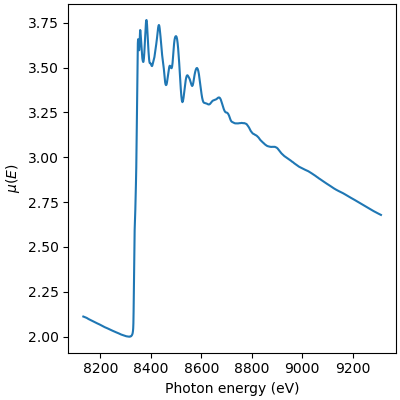

In [14]:
E, I0, It, Ir, If = np.loadtxt('Ni-foil-XAS-data-from-ISS-beamline.dat',unpack=True,usecols=[0,1,2,3,4])

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.plot(E,np.log(I0/Ir))
ax.set_ylabel('$\mu(E)$')
ax.set_xlabel('Photon energy (eV)');

Sometimes, we may be interested in including some of the information from the file header in its plot title.
For example, the scan of file Ni-foil-XAS-data-from-ISS-beamline.dat started @ 06/17/2022  09:37:49
and it ended @ 06/17/2022  09:38:24, and took 34 seconds in total. We can include this info
at the title of the plot as shown below.

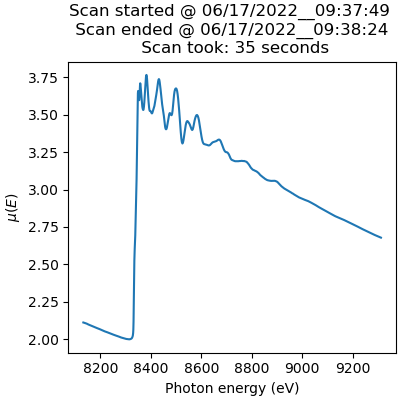

In [15]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.plot(E,np.log(I0/Ir))
ax.set_ylabel('$\mu(E)$')
ax.set_xlabel('Photon energy (eV)')
ax.set_title('Scan started @ 06/17/2022__09:37:49 \n Scan ended @ 06/17/2022__09:38:24 \n Scan took: 35 seconds');

It is fine to do this header reading manually, but if we are dealing with hundreds of files, that will be incredibly time-consuming. Instead, we can extract the date and time information from the file using Python functions. We can recreate the plot from above, but without "hard-coding" in the date and time.

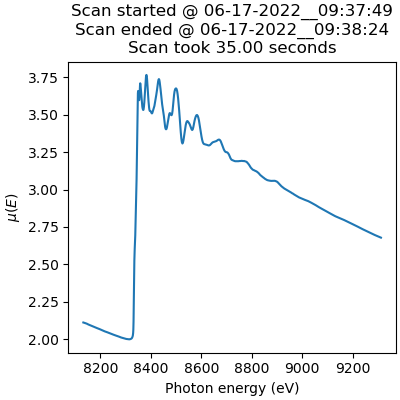

In [16]:
# This is a method which takes in a data file and outputs the start and end times in the file header (if it can find them).
# It works by searching line by line for date and time labels, and then uses formatting to match to the date and time on
# a given line where it finds a label. These dates/times are "stripped" using a method from the datetime library.
def get_title_str(datfile):
    import datetime
    with open(datfile) as datfile:
        lines = datfile.readlines()
        for e,line in enumerate(lines):
            if line.startswith('# Scan.start_time:'):
                dt_start = datetime.datetime.strptime("%s_%s"%(line.split()[2], line.split()[3]), "%m/%d/%Y_%H:%M:%S")
            elif line.startswith('# Scan.end_time:'):
                dt_stop = datetime.datetime.strptime("%s_%s"%(line.split()[2], line.split()[3]), "%m/%d/%Y_%H:%M:%S")
            elif line.startswith('# Start time:'):
                dt_start = datetime.datetime.strptime("%s_%s"%(line.split()[3], line.split()[4]), "%m/%d/%Y_%H:%M:%S")
            elif line.startswith('# Stop time:'):
                dt_stop = datetime.datetime.strptime("%s_%s"%(line.split()[3], line.split()[4]), "%m/%d/%Y_%H:%M:%S")

    title_str = '%s\n%s\nScan took %.2f seconds'%(
        dt_start.strftime("Scan started @ %m-%d-%Y__%H:%M:%S"),
        dt_stop.strftime("Scan ended @ %m-%d-%Y__%H:%M:%S"),
        (dt_stop.timestamp()-dt_start.timestamp()))

    return title_str


fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.plot(E,np.log(I0/Ir))
ax.set_ylabel('$\mu(E)$')
ax.set_xlabel('Photon energy (eV)')

ax.set_title(get_title_str('Ni-foil-XAS-data-from-ISS-beamline.dat'));

The `topas.inp` file in the plain_text folder is used as an input file for the TOPAS
program (https://topas.webspace.durham.ac.uk/) which does the XRD refinement. Sometimes we may need to alter a parameter in many files such as this one, and as above, doing it manually is unfeasable. This example illustrates how to find a value in a text file and replace it with a new value, using Python methods. We use the difflib library to compare differences between two files.

In [17]:
# import regular expression library, re, allows for advanced string formatting


with open('topas.inp', 'r') as file:
    contents = file.read()

    # regex expression to search for a number as xxx.xxxx
    pattern = r'Cubic\((\d+\.\d+)\)'

    # grab the number out, and reformat it to 0.001 precision
    newvalue = format(float(re.findall(pattern, contents)[0]), ".3f")

    # create replacement string using reformatted number, and replace
    replacement = 'Cubic(' + str(newvalue) + ')'
    modified_contents = re.sub(pattern, replacement, contents)

    with open('topas_modified.inp', 'w') as newfile:
        newfile.write(modified_contents)


# import library for sequence comparisons
import difflib

with open('topas.inp') as ogfile:
    og_text = ogfile.readlines()

with open('topas_modified.inp') as newfile:
    new_text = newfile.readlines()

# output the difference between topas.inp and topas_modified.inp
for line in difflib.unified_diff(
        og_text, new_text, fromfile='topas.inp',
        tofile='topas_modified.inp', lineterm=''):
    print(line)

--- topas.inp
+++ topas_modified.inp
@@ -30,7 +30,7 @@
 		}

 

 		scale @  0.0253272279`_3.944e-005

-		Cubic(4.156826)

+		Cubic(4.157)

 		

 Out_X_Yobs_Ycalc_and_Difference("topas.dat")

 C_matrix_normalized



The `-` line tells us the string which was replaced by the `+` line.

The following cells show how to read in, and plot or explore various file types in python.

***
# Reading xls files into python

To read an excel file, we use the pandas library. It is an incredibly useful library for manipulating tabular data; think excel functionality, in Python.

In [18]:
# navigate into xls directory
os.chdir('%s/%s/%s'%(here,example_data_path,'xls'))

# list the contents of directory
os.listdir()


['25KI-LiCl-KCl_25oC.xlsx']

In [19]:
xls = pd.ExcelFile(r'25KI-LiCl-KCl_25oC.xlsx') #read file
sheetX = xls.parse(0) #read sheet 1
plt.plot(sheetX['Angles'],sheetX['Intensities']);

***
# Reading image files into python

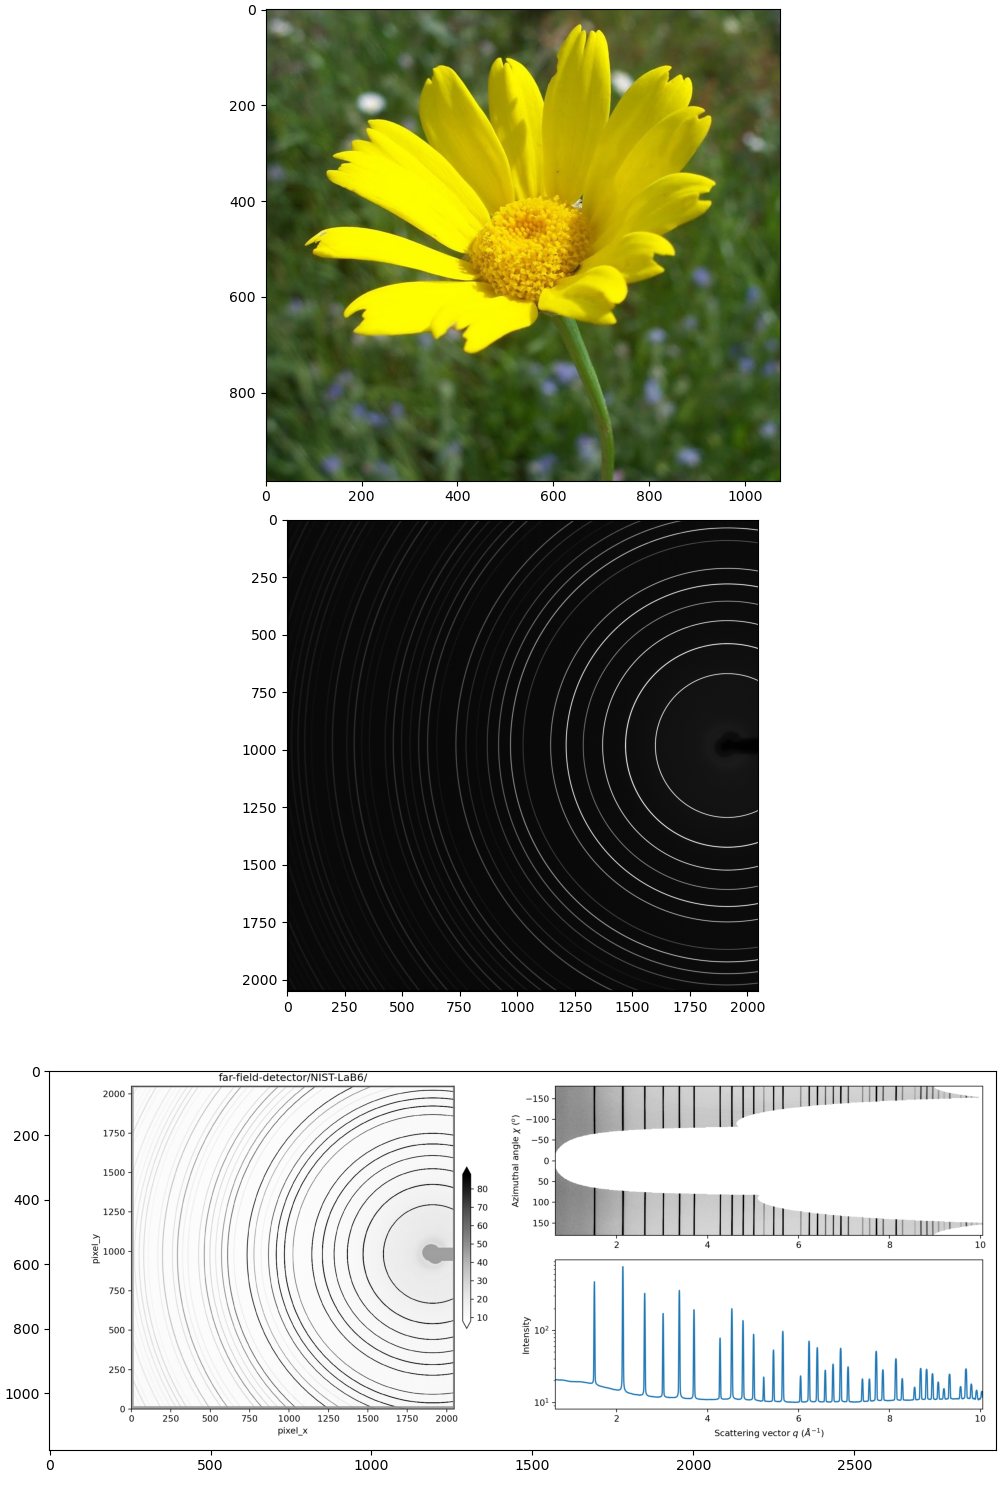

In [20]:
# navigate into image directory
os.chdir('%s/%s/%s'%(here,example_data_path,'image'))


# set up plot for images
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(10,15))

# open and display image 1
im1 = PIL.Image.open('flower.jpg')
ax1.imshow(im1)

# open and display image 2
im2 = PIL.Image.open('NIST-LaB6.tiff')
ax2.imshow(im2)

# open and display image 3
im3 = PIL.Image.open('NIST-LaB6.png')
ax3.imshow(im3);

***
# Reading xarray netCDF files into python


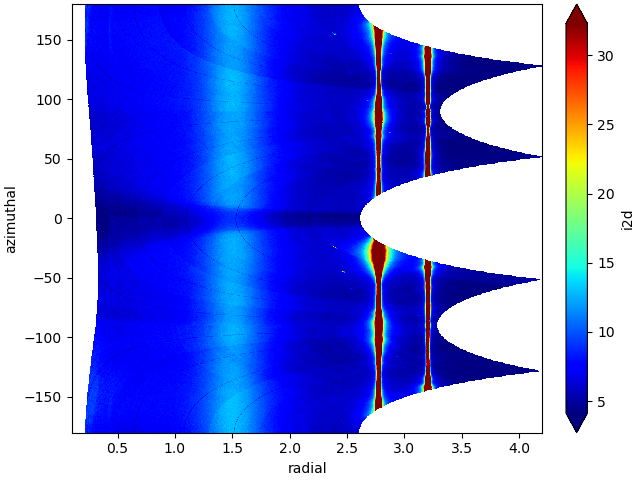

In [21]:
# navigate into plain_text directory
os.chdir('%s/%s/%s'%(here,example_data_path,'netcdf'))

# list the contents of directory
os.listdir()

with xr.open_dataset('Pt-from-28ID-2-D.nc') as ds:
    ds.load()

plt.figure()
ds.i2d.plot(robust=True,cmap='jet');

In [22]:
with xr.open_dataset('Pt-from-28ID-2-D.nc') as ds:
    ds.load();
ds

<xarray.Dataset> Size: 5MB
Dimensions:     (radial: 1641, q: 760, azimuthal: 720)
Coordinates:
  * radial      (radial) float64 13kB 0.1013 0.1038 0.1063 ... 4.196 4.199 4.201
  * q           (q) float64 6kB 2.101 2.104 2.106 2.109 ... 3.994 3.996 3.999
  * azimuthal   (azimuthal) float64 6kB -179.8 -179.3 -178.8 ... 179.3 179.8
Data variables:
    Yobs        (q) float64 6kB 1.001 1.001 1.001 1.002 ... 1.003 1.003 1.003
    Ycalc       (q) float64 6kB 2.278 2.082 1.902 1.736 ... 4.777 5.066 5.375
    Ybkg        (q) float64 6kB 0.2554 0.2553 0.2551 ... 0.1779 0.1789 0.1783
    Ybkg_arpls  (q) float64 6kB 0.01164 0.0118 0.01195 ... 0.03521 0.03524
    Ybkg_blank  (q) float64 6kB 0.2438 0.2435 0.2431 ... 0.1427 0.1437 0.1431
    Ybkg_topas  (q) float64 6kB 2.187 1.99 1.807 1.639 ... -6.464 -6.34 -6.203
    Yp1         (q) float64 6kB 2.187 1.99 1.807 1.639 ... -6.464 -6.34 -6.203
    Yp2         (q) float64 6kB 2.278 2.082 1.901 1.735 ... 4.734 5.023 5.331
    i2d         (azimuthal, radial) float32 5MB nan nan nan nan ... nan nan nan
Attributes: (12/69)
    user_note:             Platinum RT stationary
    type:                  basic
    uid_dark:              f54aaa88-ef58-4858-90e8-1f6ec182d317
    take_dark:             false
    beam:                  on
    lights:                on
    ...                    ...
    arpls_lam:             10000.0
    arpls_ratio:           0.005
    topas_inp:             \ndo_errors\nxdd topas.xy\n   r_exp 52.9798125 r_e...
    topas_out:             do_errors\nxdd 6XHOSJ7.data.xy\n   r_exp  68.55923...
    y_scale:               0.04093122505610739
    y_baseline:            1

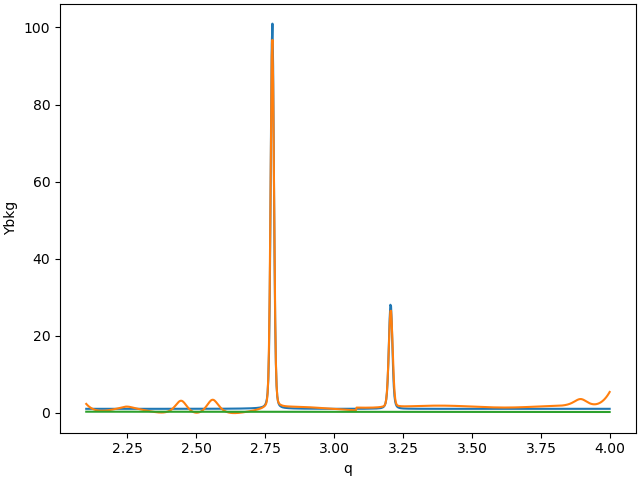

In [23]:
plt.figure()
ds.Yobs.plot()
ds.Ycalc.plot()
ds.Ybkg.plot();

***
# Reading hdf files into python

In [24]:
#navigate to hdf dir
os.chdir('%s/%s/%s'%(here,example_data_path,'hdf'))
os.listdir()

['bde401ed-ac56-45cd-b0c5_000000.h5']

In [25]:
#opens file in read mode, shows size of embeded dataset and prints contents
f = h5py.File('bde401ed-ac56-45cd-b0c5_000000.h5','r')
print(f.keys())
ds = f['entry']['data']['data']
print(ds)
ds_arr = ds[()]
ds_arr

<KeysViewHDF5 ['entry']>
<HDF5 dataset "data": shape (160, 1, 4096), type "<f8">


array([[[76.20071284, 57.40054146, 41.60040076, ...,  0.        ,
          0.        ,  0.        ]],

       [[80.60078414, 57.80054428, 41.20037208, ...,  0.        ,
          0.        ,  0.        ]],

       [[69.00064268, 59.80060578, 42.80040283, ...,  0.        ,
          0.        ,  0.        ]],

       ...,

       [[69.20059656, 57.40053506, 46.80044281, ...,  0.        ,
          0.        ,  0.        ]],

       [[69.40066421, 58.20056581, 39.80039361, ...,  0.        ,
          0.        ,  0.        ]],

       [[72.20064396, 57.60050586, 42.40037401, ...,  0.        ,
          0.        ,  0.        ]]])

***
# Reading numpy files (npy, npz) into python


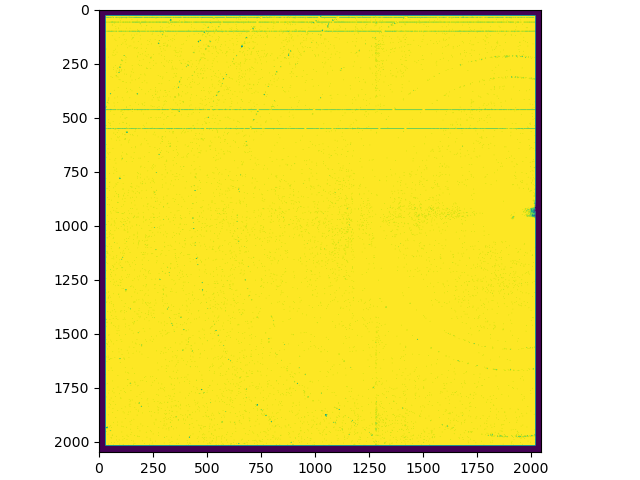

In [26]:
# navigate into npy directory
os.chdir('%s/%s/%s'%(here,example_data_path,'npy'))

file1 = np.load("Ni_calib_20190301-150927_459ff6_0001_mask.npy")
file2 = np.load("feff.npz")

plt.figure()
plt.imshow(file1);

***
# reading yaml into python


In [27]:
# navigate into yaml directory
os.chdir('%s/%s/%s'%(here,example_data_path,'yaml'))

# this is a recursive method for searching through a dictionary-like
# structure. we cna search through yaml files with this method.
def find_key(data, key):
    if isinstance(data, dict):
        if key in data:
            return data[key]
        else:
            for k, v in data.items():
                result = find_key(v, key)
                if result is not None:
                    return result
    elif isinstance(data, list):
        for item in data:
            result = find_key(item, key)
            if result is not None:
                return result

with open("from_xpdacq.yaml") as stream:
    data_loaded = yaml.safe_load(stream)
    result = find_key(data_loaded,"bt_wavelength")
    print("bt_wavelength =", result)


bt_wavelength = 0.1814
